<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [ ]:

IMG_WIDTH = 32
IMG_HEIGHT = 32


FRAME_PATH = '/content/drive/MyDrive/Dataset_HW6/'

frame_ids = next(os.walk(FRAME_PATH))[2]
X_dataset = np.zeros((len(frame_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

In [ ]:
print(X_dataset.shape)

(1005, 32, 32)


In [ ]:
print('Resizing training images and masks')
for n, id in tqdm(enumerate(frame_ids), total=len(frame_ids)):
    f_path = FRAME_PATH + id
    img = imread(f_path)[:,:]
    X_dataset[n] = img
print('Done!')

Resizing training images and masks


100%|██████████| 1005/1005 [00:02<00:00, 433.27it/s]

Done!


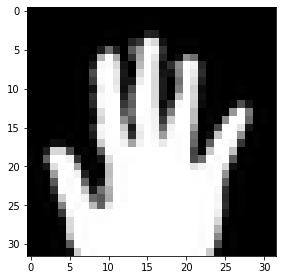

In [ ]:
imshow(X_dataset[6])
plt.show()

In [ ]:
X_train = X_dataset.astype(np.float32) / 255.0
print(np.max(X_train))

batch_size = 32
# This dataset fills a buffer with buffer_size elements,
# then randomly samples elements from this buffer,
# replacing the selected elements with new elements.
def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
  # Combines consecutive elements of this dataset into batches.
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  # Creates a Dataset that prefetches elements from this dataset
  return dataset

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize =(10, 10))

  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
      plt.axis('off')

  plt.savefig('image_epoch_{:04d}.png'.format(epoch))

1.0


## Generator Architecture

In [ ]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 128, input_shape =[num_features]),
    keras.layers.Reshape([8, 8, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

## DIscriminatore Architecture

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[32, 32, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [ ]:
# compile discriminator using binary cross entropy loss and adam optimizer
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam",metrics=['accuracy'])
# make  discriminator no-trainable as of  now
discriminator.trainable = False
# Combine both generator and discriminator
gan = keras.models.Sequential([generator, discriminator])
# compile generator using binary cross entropy loss and adam optimizer

gan.compile(loss ="binary_crossentropy", optimizer ="adam",metrics=['accuracy'])

In [ ]:
seed = tf.random.normal(shape =[batch_size, 100])
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
    disc_hist= np.zeros((epochs,2))
    gen_hist= np.zeros((epochs,2))
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:
            # create a random noise of sizebatch_size * 100
            # to passit into the generator
            noise = tf.random.normal(shape =[batch_size, num_features])
            generated_images = generator(noise)

            # take batch of generated image and real image and
            #  use them to train  the discriminator
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            a=discriminator.train_on_batch(X_fake_and_real, y1, reset_metrics=False ,return_dict = False)

            # Here we will be training our GAN model, in this step
            #  we pass noise that uses generatortogenerate the image
            #  and pass it with labels as [1] So, it can fool the discriminator
            noise = tf.random.normal(shape =[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            b=gan.train_on_batch(noise, y2, reset_metrics=False ,  return_dict = False)

            # generate images for the GIF as we go
            #generate_and_save_images(generator, epoch + 1, seed)
        disc_hist[epoch]=a
        gen_hist[epoch]=b
    generate_and_save_images(generator, epochs, seed)


    return disc_hist,gen_hist

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100


  1%|          | 1/100 [00:02<04:10,  2.53s/it]


Epoch 2/100


  2%|▏         | 2/100 [00:03<02:19,  1.42s/it]


Epoch 3/100


  3%|▎         | 3/100 [00:03<01:45,  1.08s/it]


Epoch 4/100


  4%|▍         | 4/100 [00:04<01:27,  1.09it/s]


Epoch 5/100


  5%|▌         | 5/100 [00:05<01:18,  1.22it/s]


Epoch 6/100


  6%|▌         | 6/100 [00:05<01:12,  1.30it/s]


Epoch 7/100


  7%|▋         | 7/100 [00:06<01:07,  1.37it/s]


Epoch 8/100


  8%|▊         | 8/100 [00:07<01:04,  1.42it/s]


Epoch 9/100


  9%|▉         | 9/100 [00:07<01:02,  1.45it/s]


Epoch 10/100


 10%|█         | 10/100 [00:08<01:01,  1.46it/s]


Epoch 11/100


 11%|█         | 11/100 [00:09<01:00,  1.48it/s]


Epoch 12/100


 12%|█▏        | 12/100 [00:09<00:59,  1.49it/s]


Epoch 13/100


 13%|█▎        | 13/100 [00:10<00:58,  1.50it/s]


Epoch 14/100


 14%|█▍        | 14/100 [00:11<01:11,  1.21it/s]


Epoch 15/100


 15%|█▌        | 15/100 [00:12<01:16,  1.12it/s]


Epoch 16/100


 16%|█▌        | 16/100 [00:13<01:09,  1.20it/s]


Epoch 17/100


 17%|█▋        | 17/100 [00:14<01:06,  1.25it/s]


Epoch 18/100


 18%|█▊        | 18/100 [00:14<01:03,  1.30it/s]


Epoch 19/100


 19%|█▉        | 19/100 [00:15<00:59,  1.36it/s]


Epoch 20/100


 20%|██        | 20/100 [00:16<00:57,  1.39it/s]


Epoch 21/100


 21%|██        | 21/100 [00:16<00:55,  1.42it/s]


Epoch 22/100


 22%|██▏       | 22/100 [00:17<00:54,  1.43it/s]


Epoch 23/100


 23%|██▎       | 23/100 [00:18<00:52,  1.46it/s]


Epoch 24/100


 24%|██▍       | 24/100 [00:18<00:51,  1.47it/s]


Epoch 25/100


 25%|██▌       | 25/100 [00:19<00:50,  1.49it/s]


Epoch 26/100


 26%|██▌       | 26/100 [00:20<00:49,  1.49it/s]


Epoch 27/100


 27%|██▋       | 27/100 [00:20<00:49,  1.49it/s]


Epoch 28/100


 28%|██▊       | 28/100 [00:21<00:48,  1.49it/s]


Epoch 29/100


 29%|██▉       | 29/100 [00:22<00:47,  1.49it/s]


Epoch 30/100


 30%|███       | 30/100 [00:22<00:46,  1.50it/s]


Epoch 31/100


 31%|███       | 31/100 [00:23<00:45,  1.52it/s]


Epoch 32/100


 32%|███▏      | 32/100 [00:24<00:44,  1.52it/s]


Epoch 33/100


 33%|███▎      | 33/100 [00:25<00:56,  1.19it/s]


Epoch 34/100


 34%|███▍      | 34/100 [00:26<00:52,  1.25it/s]


Epoch 35/100


 35%|███▌      | 35/100 [00:27<01:01,  1.06it/s]


Epoch 36/100


 36%|███▌      | 36/100 [00:28<01:06,  1.04s/it]


Epoch 37/100


 37%|███▋      | 37/100 [00:29<00:58,  1.08it/s]


Epoch 38/100


 38%|███▊      | 38/100 [00:29<00:52,  1.19it/s]


Epoch 39/100


 39%|███▉      | 39/100 [00:30<00:48,  1.27it/s]


Epoch 40/100


 40%|████      | 40/100 [00:31<00:44,  1.33it/s]


Epoch 41/100


 41%|████      | 41/100 [00:31<00:42,  1.38it/s]


Epoch 42/100


 42%|████▏     | 42/100 [00:32<00:40,  1.42it/s]


Epoch 43/100


 43%|████▎     | 43/100 [00:33<00:39,  1.45it/s]


Epoch 44/100


 44%|████▍     | 44/100 [00:33<00:37,  1.48it/s]


Epoch 45/100


 45%|████▌     | 45/100 [00:34<00:36,  1.50it/s]


Epoch 46/100


 46%|████▌     | 46/100 [00:35<00:35,  1.51it/s]


Epoch 47/100


 47%|████▋     | 47/100 [00:35<00:34,  1.53it/s]


Epoch 48/100


 48%|████▊     | 48/100 [00:36<00:34,  1.53it/s]


Epoch 49/100


 49%|████▉     | 49/100 [00:37<00:33,  1.54it/s]


Epoch 50/100


 50%|█████     | 50/100 [00:37<00:32,  1.54it/s]


Epoch 51/100


 51%|█████     | 51/100 [00:38<00:31,  1.55it/s]


Epoch 52/100


 52%|█████▏    | 52/100 [00:39<00:31,  1.54it/s]


Epoch 53/100


 53%|█████▎    | 53/100 [00:39<00:30,  1.52it/s]


Epoch 54/100


 54%|█████▍    | 54/100 [00:40<00:30,  1.53it/s]


Epoch 55/100


 55%|█████▌    | 55/100 [00:41<00:29,  1.52it/s]


Epoch 56/100


 56%|█████▌    | 56/100 [00:41<00:28,  1.52it/s]


Epoch 57/100


 57%|█████▋    | 57/100 [00:42<00:28,  1.52it/s]


Epoch 58/100


 58%|█████▊    | 58/100 [00:43<00:28,  1.49it/s]


Epoch 59/100


 59%|█████▉    | 59/100 [00:43<00:27,  1.49it/s]


Epoch 60/100


 60%|██████    | 60/100 [00:44<00:26,  1.49it/s]


Epoch 61/100


 61%|██████    | 61/100 [00:45<00:26,  1.49it/s]


Epoch 62/100


 62%|██████▏   | 62/100 [00:45<00:25,  1.50it/s]


Epoch 63/100


 63%|██████▎   | 63/100 [00:46<00:24,  1.51it/s]


Epoch 64/100


 64%|██████▍   | 64/100 [00:47<00:23,  1.52it/s]


Epoch 65/100


 65%|██████▌   | 65/100 [00:47<00:23,  1.50it/s]


Epoch 66/100


 66%|██████▌   | 66/100 [00:48<00:22,  1.51it/s]


Epoch 67/100


 67%|██████▋   | 67/100 [00:49<00:22,  1.49it/s]


Epoch 68/100


 68%|██████▊   | 68/100 [00:49<00:21,  1.49it/s]


Epoch 69/100


 69%|██████▉   | 69/100 [00:50<00:20,  1.50it/s]


Epoch 70/100


 70%|███████   | 70/100 [00:51<00:19,  1.50it/s]


Epoch 71/100


 71%|███████   | 71/100 [00:51<00:19,  1.49it/s]


Epoch 72/100


 72%|███████▏  | 72/100 [00:52<00:18,  1.50it/s]


Epoch 73/100


 73%|███████▎  | 73/100 [00:53<00:17,  1.50it/s]


Epoch 74/100


 74%|███████▍  | 74/100 [00:53<00:17,  1.50it/s]


Epoch 75/100


 75%|███████▌  | 75/100 [00:54<00:16,  1.50it/s]


Epoch 76/100


 76%|███████▌  | 76/100 [00:55<00:16,  1.49it/s]


Epoch 77/100


 77%|███████▋  | 77/100 [00:55<00:15,  1.50it/s]


Epoch 78/100


 78%|███████▊  | 78/100 [00:56<00:14,  1.50it/s]


Epoch 79/100


 79%|███████▉  | 79/100 [00:57<00:14,  1.49it/s]


Epoch 80/100


 80%|████████  | 80/100 [00:57<00:13,  1.50it/s]


Epoch 81/100


 81%|████████  | 81/100 [00:58<00:12,  1.50it/s]


Epoch 82/100


 82%|████████▏ | 82/100 [00:59<00:12,  1.49it/s]


Epoch 83/100


 83%|████████▎ | 83/100 [00:59<00:11,  1.49it/s]


Epoch 84/100


 84%|████████▍ | 84/100 [01:00<00:10,  1.49it/s]


Epoch 85/100


 85%|████████▌ | 85/100 [01:01<00:10,  1.49it/s]


Epoch 86/100


 86%|████████▌ | 86/100 [01:01<00:09,  1.49it/s]


Epoch 87/100


 87%|████████▋ | 87/100 [01:02<00:08,  1.50it/s]


Epoch 88/100


 88%|████████▊ | 88/100 [01:03<00:07,  1.50it/s]


Epoch 89/100


 89%|████████▉ | 89/100 [01:03<00:07,  1.49it/s]


Epoch 90/100


 90%|█████████ | 90/100 [01:04<00:06,  1.49it/s]


Epoch 91/100


 91%|█████████ | 91/100 [01:05<00:06,  1.48it/s]


Epoch 92/100


 92%|█████████▏| 92/100 [01:05<00:05,  1.49it/s]


Epoch 93/100


 93%|█████████▎| 93/100 [01:06<00:04,  1.51it/s]


Epoch 94/100


 94%|█████████▍| 94/100 [01:07<00:03,  1.52it/s]


Epoch 95/100


 95%|█████████▌| 95/100 [01:07<00:03,  1.54it/s]


Epoch 96/100


 96%|█████████▌| 96/100 [01:08<00:02,  1.53it/s]


Epoch 97/100


 97%|█████████▋| 97/100 [01:08<00:01,  1.55it/s]


Epoch 98/100


 98%|█████████▊| 98/100 [01:09<00:01,  1.53it/s]


Epoch 99/100


 99%|█████████▉| 99/100 [01:10<00:00,  1.51it/s]


Epoch 100/100


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


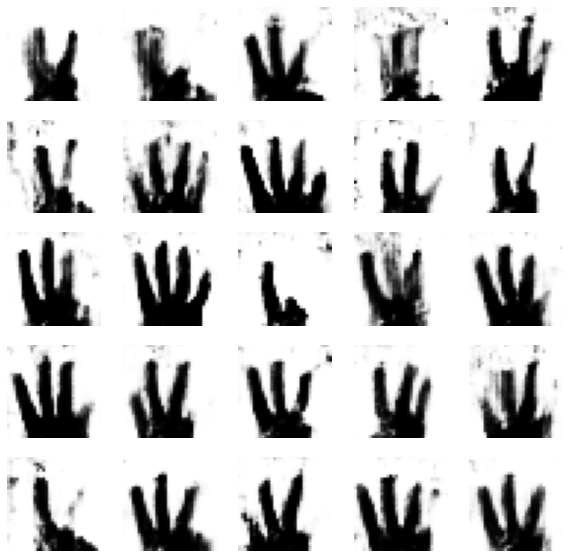

In [ ]:
# reshape to add a color map
x_train_dcgan = X_train.reshape(-1, 32, 32, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
disc_hist,gen_hist = train_dcgan(gan, dataset, batch_size, num_features, epochs = 100)

Text(0.5, 1.0, 'Accuracy')

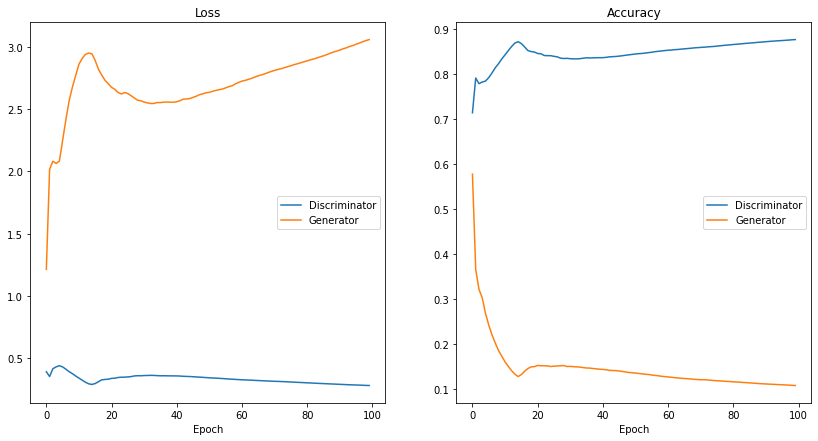

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(0,100))


f = plt.figure()
f.set_figwidth(14)
f.set_figheight(7)

plt.subplot(1, 2, 1)
plt.plot(epoch,disc_hist[:,0])
plt.plot(epoch,gen_hist[:,0])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(epoch,disc_hist[:,1])
plt.plot(epoch,gen_hist[:,1])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("Accuracy")


# Stabalizing

## First Technique: One Sided Label Smoothing

In [ ]:
seed = tf.random.normal(shape =[batch_size, 100])
from numpy.random import random

def train_dcgan_smoothing(gan, dataset, batch_size, num_features, epochs = 5):
    disc_hist= np.zeros((epochs,2))
    gen_hist= np.zeros((epochs,2))
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:
            # create a random noise of sizebatch_size * 100
            # to passit into the generator
            noise = tf.random.normal(shape =[batch_size, num_features])
            generated_images = generator(noise)

            # take batch of generated image and real image and
            #  use them to train  the discriminator
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1_neg =  [[0.]] * batch_size
            y1_neg_smoothed = y1_neg + 0.3*random(np.array(y1_neg).shape)
            y1_pos = [[1.]] * batch_size
            y1_pos_smoothed = y1_pos + 0.5*random(np.array(y1_pos).shape)-0.25
            y1 = tf.concat([y1_neg_smoothed , y1_pos_smoothed],0)

            discriminator.trainable = True
            a=discriminator.train_on_batch(X_fake_and_real, y1, reset_metrics=False ,return_dict = False)

            # Here we will be training our GAN model, in this step
            #  we pass noise that uses generatortogenerate the image
            #  and pass it with labels as [1] So, it can fool the discriminator
            noise = tf.random.normal(shape =[batch_size, num_features])
            #y2_pos = [[1.]] * batch_size
            #y2_pos_smoothed = y2_pos + 0.5*random(y2_pos.shape)-0.25
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            b=gan.train_on_batch(noise, y2, reset_metrics=False ,  return_dict = False)

            # generate images for the GIF as we go
            #generate_and_save_images(generator, epoch + 1, seed)
        disc_hist[epoch]=a
        gen_hist[epoch]=b
    generate_and_save_images(generator, epochs, seed)


    return disc_hist,gen_hist

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100


  1%|          | 1/100 [00:00<01:18,  1.26it/s]


Epoch 2/100


  2%|▏         | 2/100 [00:01<01:14,  1.32it/s]


Epoch 3/100


  3%|▎         | 3/100 [00:02<01:14,  1.31it/s]


Epoch 4/100


  4%|▍         | 4/100 [00:03<01:11,  1.34it/s]


Epoch 5/100


  5%|▌         | 5/100 [00:03<01:08,  1.38it/s]


Epoch 6/100


  6%|▌         | 6/100 [00:04<01:07,  1.40it/s]


Epoch 7/100


  7%|▋         | 7/100 [00:05<01:05,  1.41it/s]


Epoch 8/100


  8%|▊         | 8/100 [00:05<01:05,  1.41it/s]


Epoch 9/100


  9%|▉         | 9/100 [00:07<01:20,  1.13it/s]


Epoch 10/100


 10%|█         | 10/100 [00:07<01:15,  1.19it/s]


Epoch 11/100


 11%|█         | 11/100 [00:08<01:16,  1.16it/s]


Epoch 12/100


 12%|█▏        | 12/100 [00:09<01:19,  1.11it/s]


Epoch 13/100


 13%|█▎        | 13/100 [00:10<01:20,  1.08it/s]


Epoch 14/100


 14%|█▍        | 14/100 [00:11<01:14,  1.16it/s]


Epoch 15/100


 15%|█▌        | 15/100 [00:12<01:10,  1.21it/s]


Epoch 16/100


 16%|█▌        | 16/100 [00:12<01:07,  1.25it/s]


Epoch 17/100


 17%|█▋        | 17/100 [00:13<01:04,  1.29it/s]


Epoch 18/100


 18%|█▊        | 18/100 [00:14<01:01,  1.34it/s]


Epoch 19/100


 19%|█▉        | 19/100 [00:14<00:59,  1.36it/s]


Epoch 20/100


 20%|██        | 20/100 [00:15<00:57,  1.39it/s]


Epoch 21/100


 21%|██        | 21/100 [00:16<00:56,  1.41it/s]


Epoch 22/100


 22%|██▏       | 22/100 [00:17<00:54,  1.42it/s]


Epoch 23/100


 23%|██▎       | 23/100 [00:17<00:54,  1.43it/s]


Epoch 24/100


 24%|██▍       | 24/100 [00:18<00:53,  1.43it/s]


Epoch 25/100


 25%|██▌       | 25/100 [00:19<00:52,  1.44it/s]


Epoch 26/100


 26%|██▌       | 26/100 [00:19<00:51,  1.45it/s]


Epoch 27/100


 27%|██▋       | 27/100 [00:20<00:50,  1.44it/s]


Epoch 28/100


 28%|██▊       | 28/100 [00:21<00:49,  1.45it/s]


Epoch 29/100


 29%|██▉       | 29/100 [00:21<00:48,  1.46it/s]


Epoch 30/100


 30%|███       | 30/100 [00:22<00:47,  1.47it/s]


Epoch 31/100


 31%|███       | 31/100 [00:23<00:49,  1.40it/s]


Epoch 32/100


 32%|███▏      | 32/100 [00:24<00:47,  1.42it/s]


Epoch 33/100


 33%|███▎      | 33/100 [00:24<00:47,  1.42it/s]


Epoch 34/100


 34%|███▍      | 34/100 [00:25<00:46,  1.43it/s]


Epoch 35/100


 35%|███▌      | 35/100 [00:26<00:44,  1.45it/s]


Epoch 36/100


 36%|███▌      | 36/100 [00:27<00:55,  1.16it/s]


Epoch 37/100


 37%|███▋      | 37/100 [00:28<01:02,  1.01it/s]


Epoch 38/100


 38%|███▊      | 38/100 [00:29<01:00,  1.03it/s]


Epoch 39/100


 39%|███▉      | 39/100 [00:30<00:54,  1.12it/s]


Epoch 40/100


 40%|████      | 40/100 [00:31<00:51,  1.16it/s]


Epoch 41/100


 41%|████      | 41/100 [00:32<00:53,  1.10it/s]


Epoch 42/100


 42%|████▏     | 42/100 [00:33<00:54,  1.06it/s]


Epoch 43/100


 43%|████▎     | 43/100 [00:34<01:00,  1.05s/it]


Epoch 44/100


 44%|████▍     | 44/100 [00:35<00:52,  1.06it/s]


Epoch 45/100


 45%|████▌     | 45/100 [00:35<00:47,  1.15it/s]


Epoch 46/100


 46%|████▌     | 46/100 [00:36<00:44,  1.20it/s]


Epoch 47/100


 47%|████▋     | 47/100 [00:37<00:41,  1.28it/s]


Epoch 48/100


 48%|████▊     | 48/100 [00:37<00:39,  1.31it/s]


Epoch 49/100


 49%|████▉     | 49/100 [00:38<00:38,  1.33it/s]


Epoch 50/100


 50%|█████     | 50/100 [00:41<01:04,  1.29s/it]


Epoch 51/100


 51%|█████     | 51/100 [00:41<00:55,  1.14s/it]


Epoch 52/100


 52%|█████▏    | 52/100 [00:42<00:48,  1.00s/it]


Epoch 53/100


 53%|█████▎    | 53/100 [00:43<00:42,  1.10it/s]


Epoch 54/100


 54%|█████▍    | 54/100 [00:44<00:38,  1.19it/s]


Epoch 55/100


 55%|█████▌    | 55/100 [00:44<00:36,  1.24it/s]


Epoch 56/100


 56%|█████▌    | 56/100 [00:45<00:33,  1.31it/s]


Epoch 57/100


 57%|█████▋    | 57/100 [00:46<00:31,  1.35it/s]


Epoch 58/100


 58%|█████▊    | 58/100 [00:46<00:30,  1.38it/s]


Epoch 59/100


 59%|█████▉    | 59/100 [00:47<00:29,  1.39it/s]


Epoch 60/100


 60%|██████    | 60/100 [00:48<00:28,  1.41it/s]


Epoch 61/100


 61%|██████    | 61/100 [00:48<00:27,  1.42it/s]


Epoch 62/100


 62%|██████▏   | 62/100 [00:50<00:33,  1.15it/s]


Epoch 63/100


 63%|██████▎   | 63/100 [00:50<00:30,  1.21it/s]


Epoch 64/100


 64%|██████▍   | 64/100 [00:51<00:28,  1.28it/s]


Epoch 65/100


 65%|██████▌   | 65/100 [00:52<00:26,  1.34it/s]


Epoch 66/100


 66%|██████▌   | 66/100 [00:52<00:24,  1.37it/s]


Epoch 67/100


 67%|██████▋   | 67/100 [00:53<00:23,  1.40it/s]


Epoch 68/100


 68%|██████▊   | 68/100 [00:54<00:22,  1.41it/s]


Epoch 69/100


 69%|██████▉   | 69/100 [00:54<00:21,  1.41it/s]


Epoch 70/100


 70%|███████   | 70/100 [00:55<00:21,  1.43it/s]


Epoch 71/100


 71%|███████   | 71/100 [00:56<00:20,  1.44it/s]


Epoch 72/100


 72%|███████▏  | 72/100 [00:57<00:19,  1.44it/s]


Epoch 73/100


 73%|███████▎  | 73/100 [00:57<00:18,  1.45it/s]


Epoch 74/100


 74%|███████▍  | 74/100 [00:58<00:18,  1.44it/s]


Epoch 75/100


 75%|███████▌  | 75/100 [00:59<00:17,  1.42it/s]


Epoch 76/100


 76%|███████▌  | 76/100 [00:59<00:16,  1.42it/s]


Epoch 77/100


 77%|███████▋  | 77/100 [01:00<00:15,  1.44it/s]


Epoch 78/100


 78%|███████▊  | 78/100 [01:01<00:15,  1.42it/s]


Epoch 79/100


 79%|███████▉  | 79/100 [01:01<00:14,  1.40it/s]


Epoch 80/100


 80%|████████  | 80/100 [01:02<00:14,  1.42it/s]


Epoch 81/100


 81%|████████  | 81/100 [01:03<00:13,  1.41it/s]


Epoch 82/100


 82%|████████▏ | 82/100 [01:04<00:12,  1.40it/s]


Epoch 83/100


 83%|████████▎ | 83/100 [01:04<00:12,  1.41it/s]


Epoch 84/100


 84%|████████▍ | 84/100 [01:05<00:11,  1.42it/s]


Epoch 85/100


 85%|████████▌ | 85/100 [01:06<00:10,  1.43it/s]


Epoch 86/100


 86%|████████▌ | 86/100 [01:06<00:09,  1.43it/s]


Epoch 87/100


 87%|████████▋ | 87/100 [01:07<00:09,  1.40it/s]


Epoch 88/100


 88%|████████▊ | 88/100 [01:08<00:08,  1.40it/s]


Epoch 89/100


 89%|████████▉ | 89/100 [01:09<00:07,  1.41it/s]


Epoch 90/100


 90%|█████████ | 90/100 [01:10<00:08,  1.14it/s]


Epoch 91/100


 91%|█████████ | 91/100 [01:11<00:07,  1.22it/s]


Epoch 92/100


 92%|█████████▏| 92/100 [01:11<00:06,  1.30it/s]


Epoch 93/100


 93%|█████████▎| 93/100 [01:12<00:05,  1.34it/s]


Epoch 94/100


 94%|█████████▍| 94/100 [01:13<00:04,  1.36it/s]


Epoch 95/100


 95%|█████████▌| 95/100 [01:13<00:03,  1.40it/s]


Epoch 96/100


 96%|█████████▌| 96/100 [01:14<00:02,  1.42it/s]


Epoch 97/100


 97%|█████████▋| 97/100 [01:15<00:02,  1.43it/s]


Epoch 98/100


 98%|█████████▊| 98/100 [01:15<00:01,  1.45it/s]


Epoch 99/100


 99%|█████████▉| 99/100 [01:16<00:00,  1.46it/s]


Epoch 100/100


100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


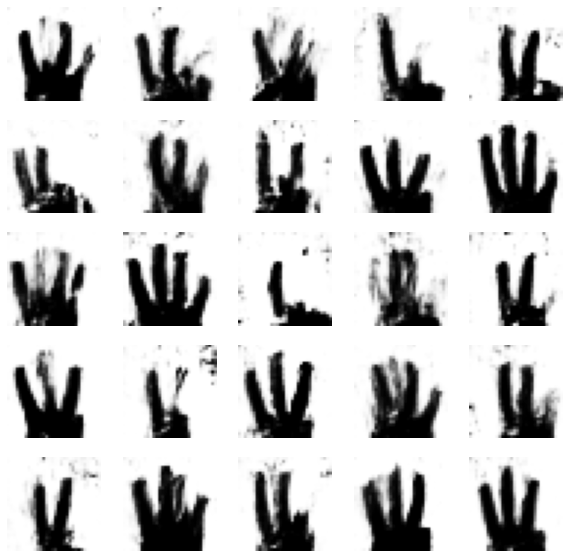

In [ ]:
# reshape to add a color map
x_train_dcgan = X_train.reshape(-1, 32, 32, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
disc_hist,gen_hist = train_dcgan_smoothing(gan, dataset, batch_size, num_features, epochs = 100)

Text(0.5, 1.0, 'Accuracy')

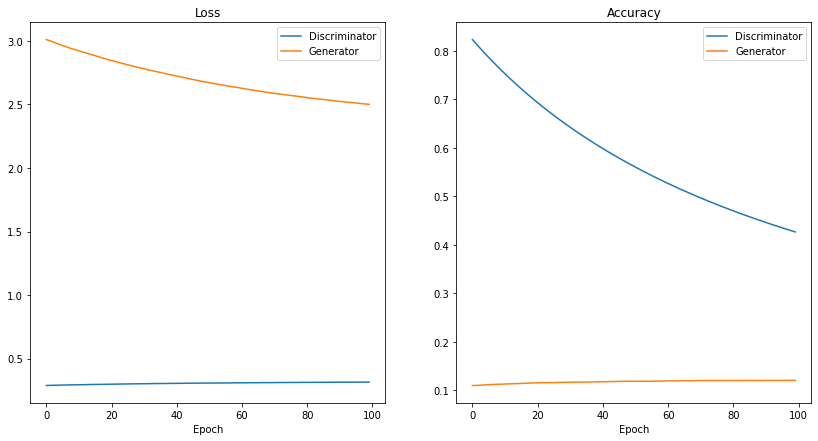

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(0,100))


f = plt.figure()
f.set_figwidth(14)
f.set_figheight(7)

plt.subplot(1, 2, 1)
plt.plot(epoch,disc_hist[:,0])
plt.plot(epoch,gen_hist[:,0])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(epoch,disc_hist[:,1])
plt.plot(epoch,gen_hist[:,1])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("Accuracy")


## Second Technique: Add Noise

In [ ]:
from numpy.random import choice
def noisy_labels(y, p_flip):
	y=y.numpy()
  # determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

seed = tf.random.normal(shape =[batch_size, 100])


def train_dcgan_Noisy_label(gan, dataset, batch_size, num_features, epochs = 5):
    disc_hist= np.zeros((epochs,2))
    gen_hist= np.zeros((epochs,2))
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print()
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:
            # create a random noise of sizebatch_size * 100
            # to passit into the generator
            noise = tf.random.normal(shape =[batch_size, num_features])
            generated_images = generator(noise)

            # take batch of generated image and real image and
            #  use them to train  the discriminator
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            y1= noisy_labels(y1, 0.08)
            discriminator.trainable = True
            a=discriminator.train_on_batch(X_fake_and_real, y1, reset_metrics=False ,return_dict = False)


            # Here we will be training our GAN model, in this step
            #  we pass noise that uses generatortogenerate the image
            #  and pass it with labels as [1] So, it can fool the discriminator
            noise = tf.random.normal(shape =[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            b=gan.train_on_batch(noise, y2, reset_metrics=False ,  return_dict = False)

            # generate images for the GIF as we go
            #generate_and_save_images(generator, epoch + 1, seed)
        disc_hist[epoch]=a
        gen_hist[epoch]=b
    generate_and_save_images(generator, epochs, seed)


    return disc_hist,gen_hist

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100


  1%|          | 1/100 [00:00<01:11,  1.39it/s]


Epoch 2/100


  2%|▏         | 2/100 [00:01<01:08,  1.43it/s]


Epoch 3/100


  3%|▎         | 3/100 [00:02<01:07,  1.43it/s]


Epoch 4/100


  4%|▍         | 4/100 [00:02<01:06,  1.45it/s]


Epoch 5/100


  5%|▌         | 5/100 [00:03<01:05,  1.46it/s]


Epoch 6/100


  6%|▌         | 6/100 [00:04<01:04,  1.47it/s]


Epoch 7/100


  7%|▋         | 7/100 [00:04<01:02,  1.48it/s]


Epoch 8/100


  8%|▊         | 8/100 [00:05<01:02,  1.47it/s]


Epoch 9/100


  9%|▉         | 9/100 [00:06<01:01,  1.48it/s]


Epoch 10/100


 10%|█         | 10/100 [00:06<01:00,  1.49it/s]


Epoch 11/100


 11%|█         | 11/100 [00:07<01:00,  1.46it/s]


Epoch 12/100


 12%|█▏        | 12/100 [00:08<00:59,  1.47it/s]


Epoch 13/100


 13%|█▎        | 13/100 [00:08<00:58,  1.49it/s]


Epoch 14/100


 14%|█▍        | 14/100 [00:09<00:57,  1.49it/s]


Epoch 15/100


 15%|█▌        | 15/100 [00:10<00:57,  1.49it/s]


Epoch 16/100


 16%|█▌        | 16/100 [00:10<00:56,  1.50it/s]


Epoch 17/100


 17%|█▋        | 17/100 [00:11<00:55,  1.49it/s]


Epoch 18/100


 18%|█▊        | 18/100 [00:12<00:55,  1.49it/s]


Epoch 19/100


 19%|█▉        | 19/100 [00:12<00:54,  1.49it/s]


Epoch 20/100


 20%|██        | 20/100 [00:13<00:53,  1.48it/s]


Epoch 21/100


 21%|██        | 21/100 [00:14<00:53,  1.48it/s]


Epoch 22/100


 22%|██▏       | 22/100 [00:14<00:53,  1.47it/s]


Epoch 23/100


 23%|██▎       | 23/100 [00:15<00:53,  1.45it/s]


Epoch 24/100


 24%|██▍       | 24/100 [00:16<00:51,  1.47it/s]


Epoch 25/100


 25%|██▌       | 25/100 [00:17<00:51,  1.45it/s]


Epoch 26/100


 26%|██▌       | 26/100 [00:17<00:50,  1.45it/s]


Epoch 27/100


 27%|██▋       | 27/100 [00:18<00:50,  1.45it/s]


Epoch 28/100


 28%|██▊       | 28/100 [00:19<00:50,  1.44it/s]


Epoch 29/100


 29%|██▉       | 29/100 [00:19<00:49,  1.44it/s]


Epoch 30/100


 30%|███       | 30/100 [00:20<00:48,  1.45it/s]


Epoch 31/100


 31%|███       | 31/100 [00:21<00:52,  1.33it/s]


Epoch 32/100


 32%|███▏      | 32/100 [00:22<01:02,  1.09it/s]


Epoch 33/100


 33%|███▎      | 33/100 [00:23<01:05,  1.02it/s]


Epoch 34/100


 34%|███▍      | 34/100 [00:24<00:58,  1.12it/s]


Epoch 35/100


 35%|███▌      | 35/100 [00:25<00:54,  1.20it/s]


Epoch 36/100


 36%|███▌      | 36/100 [00:25<00:50,  1.26it/s]


Epoch 37/100


 37%|███▋      | 37/100 [00:26<00:48,  1.30it/s]


Epoch 38/100


 38%|███▊      | 38/100 [00:27<00:46,  1.33it/s]


Epoch 39/100


 39%|███▉      | 39/100 [00:27<00:44,  1.37it/s]


Epoch 40/100


 40%|████      | 40/100 [00:28<00:43,  1.39it/s]


Epoch 41/100


 41%|████      | 41/100 [00:29<00:41,  1.42it/s]


Epoch 42/100


 42%|████▏     | 42/100 [00:30<00:40,  1.44it/s]


Epoch 43/100


 43%|████▎     | 43/100 [00:30<00:39,  1.45it/s]


Epoch 44/100


 44%|████▍     | 44/100 [00:31<00:38,  1.46it/s]


Epoch 45/100


 45%|████▌     | 45/100 [00:32<00:37,  1.45it/s]


Epoch 46/100


 46%|████▌     | 46/100 [00:32<00:37,  1.45it/s]


Epoch 47/100


 47%|████▋     | 47/100 [00:33<00:36,  1.45it/s]


Epoch 48/100


 48%|████▊     | 48/100 [00:34<00:35,  1.46it/s]


Epoch 49/100


 49%|████▉     | 49/100 [00:34<00:34,  1.47it/s]


Epoch 50/100


 50%|█████     | 50/100 [00:35<00:33,  1.47it/s]


Epoch 51/100


 51%|█████     | 51/100 [00:36<00:33,  1.47it/s]


Epoch 52/100


 52%|█████▏    | 52/100 [00:36<00:32,  1.46it/s]


Epoch 53/100


 53%|█████▎    | 53/100 [00:37<00:32,  1.47it/s]


Epoch 54/100


 54%|█████▍    | 54/100 [00:38<00:31,  1.45it/s]


Epoch 55/100


 55%|█████▌    | 55/100 [00:38<00:30,  1.46it/s]


Epoch 56/100


 56%|█████▌    | 56/100 [00:39<00:29,  1.47it/s]


Epoch 57/100


 57%|█████▋    | 57/100 [00:40<00:29,  1.47it/s]


Epoch 58/100


 58%|█████▊    | 58/100 [00:40<00:28,  1.47it/s]


Epoch 59/100


 59%|█████▉    | 59/100 [00:42<00:35,  1.17it/s]


Epoch 60/100


 60%|██████    | 60/100 [00:42<00:33,  1.21it/s]


Epoch 61/100


 61%|██████    | 61/100 [00:43<00:30,  1.28it/s]


Epoch 62/100


 62%|██████▏   | 62/100 [00:44<00:28,  1.33it/s]


Epoch 63/100


 63%|██████▎   | 63/100 [00:44<00:27,  1.37it/s]


Epoch 64/100


 64%|██████▍   | 64/100 [00:45<00:25,  1.40it/s]


Epoch 65/100


 65%|██████▌   | 65/100 [00:46<00:24,  1.42it/s]


Epoch 66/100


 66%|██████▌   | 66/100 [00:47<00:23,  1.44it/s]


Epoch 67/100


 67%|██████▋   | 67/100 [00:48<00:28,  1.15it/s]


Epoch 68/100


 68%|██████▊   | 68/100 [00:48<00:25,  1.23it/s]


Epoch 69/100


 69%|██████▉   | 69/100 [00:49<00:23,  1.30it/s]


Epoch 70/100


 70%|███████   | 70/100 [00:50<00:22,  1.35it/s]


Epoch 71/100


 71%|███████   | 71/100 [00:51<00:21,  1.37it/s]


Epoch 72/100


 72%|███████▏  | 72/100 [00:51<00:19,  1.40it/s]


Epoch 73/100


 73%|███████▎  | 73/100 [00:52<00:19,  1.40it/s]


Epoch 74/100


 74%|███████▍  | 74/100 [00:53<00:18,  1.41it/s]


Epoch 75/100


 75%|███████▌  | 75/100 [00:53<00:17,  1.39it/s]


Epoch 76/100


 76%|███████▌  | 76/100 [00:54<00:17,  1.39it/s]


Epoch 77/100


 77%|███████▋  | 77/100 [00:55<00:16,  1.40it/s]


Epoch 78/100


 78%|███████▊  | 78/100 [00:55<00:15,  1.40it/s]


Epoch 79/100


 79%|███████▉  | 79/100 [00:56<00:14,  1.42it/s]


Epoch 80/100


 80%|████████  | 80/100 [00:57<00:14,  1.43it/s]


Epoch 81/100


 81%|████████  | 81/100 [00:58<00:13,  1.44it/s]


Epoch 82/100


 82%|████████▏ | 82/100 [00:58<00:12,  1.45it/s]


Epoch 83/100


 83%|████████▎ | 83/100 [00:59<00:11,  1.44it/s]


Epoch 84/100


 84%|████████▍ | 84/100 [01:00<00:11,  1.43it/s]


Epoch 85/100


 85%|████████▌ | 85/100 [01:00<00:10,  1.44it/s]


Epoch 86/100


 86%|████████▌ | 86/100 [01:01<00:09,  1.44it/s]


Epoch 87/100


 87%|████████▋ | 87/100 [01:02<00:09,  1.44it/s]


Epoch 88/100


 88%|████████▊ | 88/100 [01:02<00:08,  1.44it/s]


Epoch 89/100


 89%|████████▉ | 89/100 [01:03<00:07,  1.45it/s]


Epoch 90/100


 90%|█████████ | 90/100 [01:04<00:06,  1.44it/s]


Epoch 91/100


 91%|█████████ | 91/100 [01:04<00:06,  1.44it/s]


Epoch 92/100


 92%|█████████▏| 92/100 [01:05<00:05,  1.45it/s]


Epoch 93/100


 93%|█████████▎| 93/100 [01:06<00:04,  1.44it/s]


Epoch 94/100


 94%|█████████▍| 94/100 [01:07<00:04,  1.44it/s]


Epoch 95/100


 95%|█████████▌| 95/100 [01:07<00:03,  1.44it/s]


Epoch 96/100


 96%|█████████▌| 96/100 [01:08<00:02,  1.43it/s]


Epoch 97/100


 97%|█████████▋| 97/100 [01:09<00:02,  1.43it/s]


Epoch 98/100


 98%|█████████▊| 98/100 [01:09<00:01,  1.44it/s]


Epoch 99/100


 99%|█████████▉| 99/100 [01:10<00:00,  1.43it/s]


Epoch 100/100


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


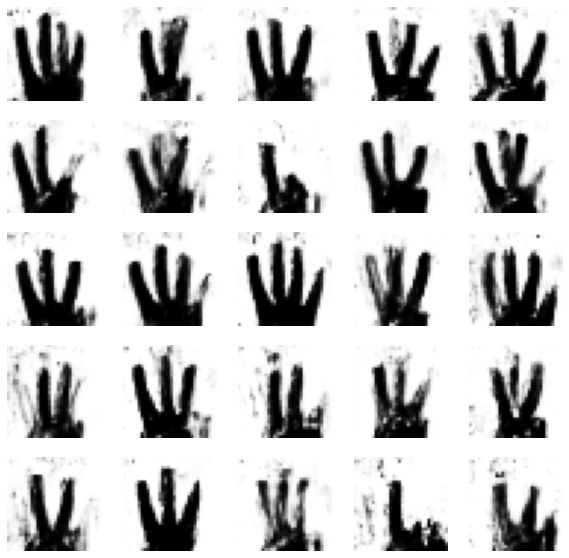

In [ ]:
# reshape to add a color map
x_train_dcgan = X_train.reshape(-1, 32, 32, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
disc_hist,gen_hist = train_dcgan_Noisy_label(gan, dataset, batch_size, num_features, epochs = 100)

Text(0.5, 1.0, 'Accuracy')

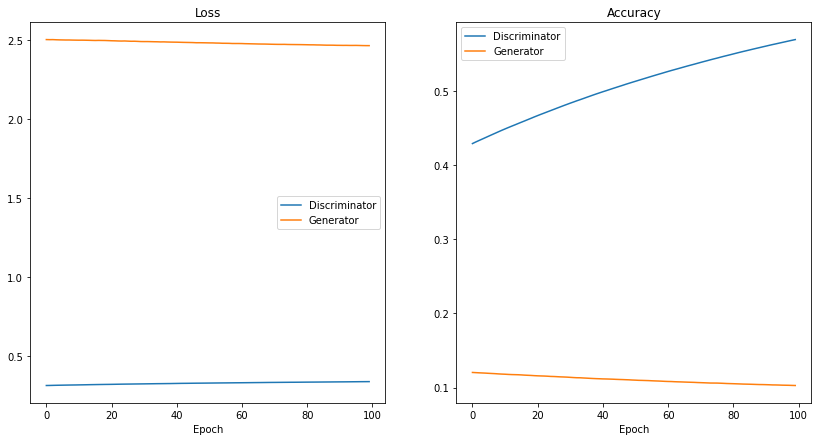

In [ ]:
import matplotlib.pyplot as plt

epoch = list(range(0,100))


f = plt.figure()
f.set_figwidth(14)
f.set_figheight(7)

plt.subplot(1, 2, 1)
plt.plot(epoch,disc_hist[:,0])
plt.plot(epoch,gen_hist[:,0])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("nelbo")
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(epoch,disc_hist[:,1])
plt.plot(epoch,gen_hist[:,1])
plt.legend(['Discriminator','Generator'])
plt.xlabel("Epoch")
#plt.ylabel("kl")
plt.title("Accuracy")